In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time

In [2]:
# set device to GPU if available otherwise use CPU
def set_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        # if there is a GPU
        print (f'Available device : {torch.cuda.get_device_name(0)}') 
    else :
        print(device)
    return device

device = set_device()

cpu


# Data

In [4]:
def furuta_H(q1,p1,q2,p2):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum 
    Inputs : 
      - q1,p1,q2,p2 (tensors) : Generalized coordinates 
    Outputs : 
      - H (tensor) : Hamiltonian function 
    Credits : 
      - Equations & constants are from Jonas's report
    ''' 

    # system constants
    g = 9.81
    Jr = 5.72*1e-5
    Lr = 0.085
    Mp = 0.024
    Lp = 0.129
    Jp = (1/12)*Mp*Lp**2

    # g = 9.81
    # Jr = 1*1e-2
    # Lr = 0.25
    # Mp = 10
    # Lp = 0.25
    # Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp



    # hamiltonian function
    H = p1**2 * (C1+C2*torch.sin(q1)**2 )+ C4*p2**2-2*p1*p2*C3*torch.cos(q1)
    H = (1/2) * (H)/(C1*C4+C4*C2*torch.sin(q1)**2 - (C3**2) * (torch.cos(q1)**2)) 
    H = H + C5*(torch.cos(q1)+1)

    return H
    
def hamiltonian_fn_furuta(coords):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum, wraps furuta_H so that it is 
      the right format for ODEint

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2

    Outputs :
      - H (tensor) : Scalar Hamiltonian function

    Credits : 
      This function takes the same structure as the one in the SymODEN repository
    '''
    q1,p1,q2,p2 = torch.split(coords,1)

    H = furuta_H(q1,p1,q2,p2)
    return H

def coord_derivatives_furuta(coords, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:
        Returns the derivatives of the generalized coordinates

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2
      - C_q1 (default=0.0, float) : coefficient of friction related to p1 ( and q1)
      - C_q2 (default=0.0, float) : coefficient of friction related to p2 ( and q2)

    Outputs :
      - dq1dt, dp1dt, dq2dt, dp2dt (tensors) : Derivatives w.r.t coords
    '''
    if coords.requires_grad is not True:
        coords.requires_grad=True

    # Hamiltonian function
    H = hamiltonian_fn_furuta(coords)

    # gradient of the hamiltornian function wrt the generalized coordinates
    dcoords = torch.autograd.grad(H, coords, create_graph=True) # !! might need to add H.sum() if batches used here later

    dHdq1, dHdp1, dHdq2, dHdp2 = torch.split(dcoords[0], 1)

    dq1dt = dHdp1
    dp1dt = -dHdq1 -C_q1*dHdp1
    dq2dt = dHdp2
    dp2dt = -dHdq2 -C_q2*dHdp2

    return dq1dt, dp1dt, dq2dt, dp2dt
    
def dynamics_fn_furuta(t, coords, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:
    Function that returns the gradient (in form of a function) of a Hamiltonian function
    Inputs : 
      - t () : 
      - coords () : generalized coordinates
      - u () : system input
      - C () : dissipation coefficient

    Outputs :
      - S () : Symplectic gradient

    Credits : 
      - This function has a similar structure as the one in the SymODEN repository
    '''

    dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(coords, u, C_q1,
                                                          C_q2)

    S = torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt))
    return S


def random_uniform_two_interval():
    '''
      return x taken from a uniform distribution in one of two intervals 
      [-2,-0.3] or [0.3,2]
    Input : 
      None
    Outputs

    '''
    if torch.tensor([0.5]).bernoulli().bool():
        x = torch.zeros(1).uniform_(0.3,2)
    else:
        x = torch.zeros(1).uniform_(-2,-0.3)
    return x
    
def get_init_state():
    '''
      Returns initial states q1,p1,q2,p2 for the Furuta pendulum 
      The angular velocities ( /generalized momenmtums) are set to zero
    Inputs : 
      None
    Outputs : 
      y0(tensor) : inital condition
      
    '''
    y0 = torch.zeros(4)

    y0[0] = random_uniform_two_interval() 
    y0[2] = random_uniform_two_interval()

    y0[1]=0.0 # p1 = 0
    y0[3]=0.0 # p2 = 0
    return y0

def get_trajectory_furuta(timesteps=20, y0=None, noise_std=0.0, 
                   u=0.0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    
    

    Ts = 0.005 # sampling time 
    t_eval = torch.linspace(1, timesteps, timesteps) * Ts # evaluated times vector
    t_span = [Ts, timesteps*Ts] # [t_start, t_end]

    # get initial state
    if y0 is None:
        y0 = get_init_state()

    # solve the differential equation using odeint
    q_p = odeint(func=lambda t, coords: dynamics_fn_furuta(t, coords, u, C_q1, C_q2), 
                 y0=y0, t=t_eval, method='rk4', options=dict(step_size=Ts)) 

    q1, p1, q2, p2 = torch.chunk(q_p, 4, 1) 

    # add noise 
    q1 = (q1+torch.randn(q1.shape)*noise_std).detach().squeeze()
    p1 = (p1+torch.randn(p1.shape)*noise_std*torch.max(p1)).detach().squeeze()
    q2 = (q2+torch.randn(q2.shape)*noise_std).detach().squeeze()
    p2 = (p2+torch.randn(p2.shape)*noise_std*torch.max(p2)).detach().squeeze()
    
    # .detach() because the pytorch computational graph is no longer needed
    # only the value is needed
    # .squeeze() to have a desired dimentionality
    # *torch.max(p) otherwise noise is too big compared to the generalized momentum

    return q1, p1, q2, p2, t_eval.detach()

In [5]:
def energy_furuta(dq1dt,dq2dt,q1):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # system constants
    g = 9.81
    Jr = 5.72*1e-5
    Lr = 0.085
    Mp = 0.024
    Lp = 0.129
    Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp
    
    E = (1/2)* dq2dt**2 * (C1+C2*torch.sin(q1)**2)+ dq2dt*dq1dt*C3*torch.cos(q1)
    E = E +(1/2)*dq1dt**2 *C4+C5*torch.cos(q1)+C5

    return E

def get_energy_furuta(q1, p1, q2, p2, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    energy=[]
    derivatives=[]
    for coords in torch.stack((q1, p1, q2, p2),dim=1):

      dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(coords, u,
                                                            C_q1, C_q2)

      q1_n = coords[0]
      energy.append(energy_furuta(dq1dt,dq2dt,q1_n))
      derivatives.append(torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt)))
 
    energy = torch.hstack(energy).detach()
    derivatives = torch.vstack(derivatives).detach()
    return energy, derivatives

In [6]:
def multiple_trajectories_furuta(time_steps, num_trajectories, 
                          y0=torch.tensor([1.0,0.0,1.0,0.0]),
                          noise_std=0.0, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # the first trajectory
    q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=time_steps, 
                                                   y0=y0, noise_std=noise_std, 
                                                   u=u, C_q1=C_q1, C_q2=C_q2)
    
    energy, derivatives = get_energy_furuta(q1, p1, q2, p2, u=u, C_q1=C_q1, C_q2=C_q2)
    derivatives = derivatives.unsqueeze(dim=0)
    for _ in range(num_trajectories-1):
        # the trajectories 2 to num_trajectories
        q1_n, p1_n, q2_n, p2_n, t_eval_n = get_trajectory_furuta(
                     timesteps=time_steps, y0=y0, noise_std=noise_std, u=u, C_q1=0.0, C_q2=0.0)
        energy_n, derivatives_n = get_energy_furuta(q1_n, p1_n, q2_n, p2_n, u=u, C_q1=C_q1, C_q2=C_q2)

        q1 = torch.vstack((q1, q1_n))
        p1 = torch.vstack((p1, p1_n))
        q2 = torch.vstack((q2, q2_n))
        p2 = torch.vstack((p2, p2_n))

        
        energy = torch.vstack((energy, energy_n))
        derivatives  = torch.vstack((derivatives, derivatives_n.unsqueeze(dim=0)))
        # t_eval = torch.vstack((t_eval, t_eval_n))
      
    if num_trajectories == 1 :
        # so that the vectors will have the correct dimensions if only 1
        # trajectory is requested
        q1 = q1.unsqueeze(dim=0)
        p1 = p1.unsqueeze(dim=0)
        q2 = q2.unsqueeze(dim=0)
        p2 = p2.unsqueeze(dim=0)

        energy = energy.unsqueeze(dim=0)
        derivatives = derivatives

        #t_eval = t_eval.unsqueeze(dim=0)
    return q1, p1, q2, p2, energy, derivatives, t_eval

In [7]:
class TrajectoryDataset_furuta(Dataset):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    def __init__(self, q1, p1, q2, p2, t_eval, #energy=torch.tensor(False), 
                 derivatives, coord_type='hamiltonian' ):
        self.t_eval = t_eval
        self.coord_type = coord_type
        self.q1 = q1 # [num_trajectories, time_steps]
        self.p1 = p1
        self.q2 = q2
        self.p2 = p2
        # if energy:
        #    self.energy = energy
        #if derivatives:
        self.dq1dt = derivatives[:,:,0] # [num_trajectories, time_steps, (dq1/dt,dp1/dt,dq2/dt,dp2/dt)]
        #self.dp1dt = derivatives[:,:,1]
        self.dq2dt = derivatives[:,:,2]
        #self.dp2dt = derivatives[:,:,4]
        
    def __len__(self):
        return len(self.q1)

    def __getitem__(self, idx):
        
        if self.coord_type == 'hamiltonian':

            q1 = self.q1[idx]
            p1 = self.p1[idx]
            q2 = self.q2[idx]
            p2 = self.p2[idx]
            
            x = torch.vstack((q1,p1,q2,p2))
            
        if self.coord_type == 'newtonian':

            q1 = self.q1[idx]
            q2 = self.q2[idx]
            dq1dt = self.dq1dt[idx]
            dq2dt = self.dq2dt[idx]
            
            x = torch.vstack((q1,dq1dt,q2,dq2dt))
            
        t_eval = self.t_eval

        return x, t_eval
def data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size,
                       shuffle = True, proportion = 0.5, coord_type='newtonian'):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # split  into train and test 
    full_dataset = TrajectoryDataset_furuta(q1, p1, q2, p2, t_eval,derivatives, coord_type=coord_type)
    if proportion:

        train_size = int(proportion * len(full_dataset))
        test_size = len(full_dataset) - train_size

        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
        
        test_loader = DataLoader(
            test_dataset,
            batch_size,
            shuffle
            )    
    else:
      # if proportion is set to None don't split the dataset
        train_dataset = full_dataset
        energy_train = energy
        derivatives_train = derivatives
        t_eval_train = t_eval
        test_loader = None

    # create the dataloader object from the custom dataset
    train_loader = DataLoader(
        train_dataset,
        batch_size,
        shuffle
        )
       
    return train_loader, test_loader

In [8]:
def count_parameters(model):
    '''
    from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    Description:

    Inputs:

    Outpus:
      
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model

## Other

In [9]:
class Simple_MLP(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report

    '''
    def __init__(self, input_dim, H_net=None, device=None):
        super(Simple_MLP, self).__init__()
        self.H_net = H_net

        self.device = device
        self.input_dim = input_dim
        
        # add learnable dissipation coefficients
        self.C1_dissip = torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C1_dissip.requires_grad = True
        self.C2_dissip = torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C2_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            # q1,p1,q2,p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq1 , dHdp1, dHdq2 , dHdp2 = torch.chunk(dH,4,dim=-1)

            dq1dt = dHdp1
            dp1dt = -dHdq1 # - self.C1_dissip*dHdp1
            dq2dt = dHdp2
            dp2dt = -dHdq2 # - self.C2_dissip*dHdp2

            # symplectic gradient 
            S_h = torch.cat((dq1dt, dp1dt, dq2dt, dp2dt), 
                            dim=-1) 

            return S_h

In [10]:
def choose_nonlinearity(name):
    '''
    From the SymODEN repository

    Description:

    Inputs:

    Outpus:
      
    '''
    nl = None
    if name == 'tanh':
        nl = torch.tanh
    elif name == 'x+sin(x)^2':
        nl = lambda x: x + torch.sin(x).pow(2)
    else:
        raise ValueError("nonlinearity not recognized")
    return nl

In [11]:
class hidden_Layer(torch.nn.Module):
    '''
    Fully connected layer with activation function
    '''
    def __init__(self,hidden_dim, activation='tanh'):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_dim,hidden_dim)
        self.activation = choose_nonlinearity(activation)# activation function

    def forward(self, x):
        x=self.activation(self.fc(x))
        return x

In [12]:
class MLP(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''
    def __init__(self, input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2'):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = torch.nn.Sequential(
            *(hidden_Layer(hidden_dim, activation)
              for _ in range(nb_hidden_layers))
        ) # trick from EE-559 to define hidden layers
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = choose_nonlinearity(activation) # activation function

    def forward(self, x, separate_fields=False):
        h = self.activation( self.fc1(x) )
        h = self.hidden_layers(h) 
        return self.fc2(h)

## Autoencoder

In [13]:
class Autoencoder(torch.nn.Module):
    '''
    '''
    def __init__(self, nb_hidden_layers=1,  hidden_dim=64, activation='tanh', config = 'latent'):
        super(Autoencoder, self).__init__()
        
        self.config = config
        if self.config == 'latent':
                enc_in_dim = 4
                enc_out_dim = 2
                dec_in_dim = 4
                dec_out_dim = 4

        elif self.config == 'encoded':
                enc_in_dim = 4
                enc_out_dim = 4
                dec_in_dim = 4
                dec_out_dim = 4

        self.encoder = MLP(input_dim=enc_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=enc_out_dim, activation=activation)
        
        self.decoder = MLP(input_dim=dec_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=dec_out_dim, activation=activation)

    def forward(self, x): # x is (q, q_dot)

        if self.config == 'latent':
                q1, p1, q2, p2 = torch.split(x,1,dim=-1)

                p_hat = self.encoder(x) # coordinates in the latent space

                z = torch.stack((q1[:,:,0],p_hat[:,:,0],q2[:,:,0],p_hat[:,:,1]),dim=2) # input known q and encoded z into decoder
                
                x_hat = self.decoder(z) # coordinates back in the original space but using the decoder

                # x_hat = torch.stack((q1[:,:,0],q_dot_hat[:,:,0],q2[:,:,0],q_dot_hat[:,:,1]),dim=2)

                # x_hat = torch.stack((q1[:,:,0],q_dot_hat[:,:,0],q2[:,:,0],q_dot_hat[:,:,1]),dim=2)
        if self.config == 'encoded':
                z = self.encoder(x)
                x_hat = self.decoder(z)

        return z , x_hat

In [14]:
t1 = torch.ones(5,5,1)
t2 = torch.ones(5,5,1)*2
t3 = torch.ones(5,5,1)*3
t4 = torch.ones(5,5,1)*4

tt = torch.cat((t3,t4),dim=2)
t5 = torch.cat((t1,t2,t3,t4),dim=2)

In [15]:
tttt = torch.cat((t1,t2,tt),dim=2)

In [293]:
print(t5.shape)
t5

torch.Size([5, 5, 4])


tensor([[[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]],

        [[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]],

        [[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]],

        [[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]],

        [[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]]])

In [294]:
t8, t9 ,t10,t11= torch.split(t5,1,dim=-1)

In [295]:
t11

tensor([[[4.],
         [4.],
         [4.],
         [4.],
         [4.]],

        [[4.],
         [4.],
         [4.],
         [4.],
         [4.]],

        [[4.],
         [4.],
         [4.],
         [4.],
         [4.]],

        [[4.],
         [4.],
         [4.],
         [4.],
         [4.]],

        [[4.],
         [4.],
         [4.],
         [4.],
         [4.]]])

In [296]:
t8

tensor([[[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]]])

In [297]:
aaaaa = torch.cat

In [298]:
torch.split(aaaaa,2,dim=-1)

AttributeError: 'builtin_function_or_method' object has no attribute 'split'

In [ ]:
x,y = next(iter(train_loader))

In [ ]:
x.shape

torch.Size([1, 4, 300])

In [ ]:
x = torch.permute(x,(2,0,1))

In [ ]:
x.shape

torch.Size([300, 1, 4])

In [ ]:
aae   = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, activation='tanh', config = 'latent')

In [ ]:
a,b = aae(x)

# Train

## AE alone

### Functions

In [16]:
def L2_loss(u, v, w = False, dim = (0,1)):
    # u and v expected with shape : [time_steps,batch_size , (q1,p1,q2,p1)] 
    if torch.is_tensor(w):
        # mean only over time steps and batch_size
        loss = (((u-v)).mul(w).pow(2)).mean(dim = dim ).sum()
    else :
        loss = (((u-v)).pow(2)).mean(dim = dim ).sum()
    return loss

In [17]:
def load_model():
    H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
    model = Simple_MLP(input_dim=4, H_net=H_net, device=None) 
    model.to(device) 
    return model 

In [18]:
def load_data_device(time_steps=40, num_trajectories=10, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # create trajectories
    q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=time_steps, 
                      num_trajectories=num_trajectories, y0=None, noise_std=0.0, 
                      u=0.0,C_q1=0.0, C_q2=0.0)

    q1 = q1.to(device)
    p1 = p1.to(device)
    q2 = q2.to(device)
    p2 = p2.to(device)
    energy = energy.to(device)
    derivatives = derivatives.to(device)
    t_eval = t_eval.to(device)

    stds = torch.tensor([q1.std(),p1.std(),q2.std(),p2.std()])
    # dataloader to load data in batches
    train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=batch_size,
                          shuffle = True, proportion = proportion, coord_type=coord_type)
    return train_loader, test_loader, stds

In [ ]:
def L2_loss(u, v, w = False, dim = (0,1)):
    # u and v expected with shape : [time_steps,batch_size , (q1,p1,q2,p1)] 
    if torch.is_tensor(w):
        # mean only over time steps and batch_size
        loss = (((u-v)).pow(2).mul(w)).mean(dim = dim ).sum()
    else :
        loss = (((u-v)).pow(2)).mean(dim = dim ).sum()
    return loss

def load_model():
    H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
    model = Simple_MLP(input_dim=4, H_net=H_net, device=None) 
    model.to(device) 
    return model 

def load_data_device(time_steps=40, num_trajectories=10, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # create trajectories
    q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=time_steps, 
                      num_trajectories=num_trajectories, y0=None, noise_std=0.0, 
                      u=0.0,C_q1=0.0, C_q2=0.0)

    q1 = q1.to(device)
    p1 = p1.to(device)
    q2 = q2.to(device)
    p2 = p2.to(device)
    energy = energy.to(device)
    derivatives = derivatives.to(device)
    t_eval = t_eval.to(device)

    stds = torch.tensor([q1.std(),p1.std(),q2.std(),p2.std()])
    # dataloader to load data in batches
    train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=batch_size,
                          shuffle = True, proportion = proportion, coord_type=coord_type)
    return train_loader, test_loader, stds


In [105]:
def train_only_ae(autoencoder, 
                  model,
                  train_loader, 
                  test_loader, 
                  epochs,
                  horizon,
                  lr = 1e-3,
                  w=torch.tensor([0.1,0.1,1.0,1.0],device=device)): 
    alpha = 1.0
    beta = 1.0
    gamma = 1.0

    
    Ts = 0.005
    # params = list(model.parameters()) + list(autoencoder.parameters())
    optim = torch.optim.Adam(autoencoder.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    
    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        ae_loss = 0
        t1 = time.time()

        autoencoder.eval()
        for x, t_eval in iter(train_loader): # x is [batch_size,(q1,p1,q2,p1),time_steps]
            
            t_eval = t_eval[0,:horizon]
            x = torch.permute(x,(0,2,1)) # now x is [batch_size,time_steps,(q1,p1,q2,p1)]

            # Train the autoencoder alone for the first epochs

            z, x_hat = autoencoder(x[:, :horizon, :])
            # autoencoder only outputs q_dot_hat states
            #print(x_hat.shape)

            train_loss_batch = L2_loss(x_hat, x[:, :horizon,: ],w)
            # print(train_loss_batch.shape,train_loss_batch.item(),x[:, :horizon, [1,3]].shape)
            # print(train_loss_batch)

            train_loss = train_loss + train_loss_batch.item() 


            if not step%50:
                    n=0
                    fig, ax = plt.subplots(1, 4,figsize=(15, 4), constrained_layout=True, sharex=True)
                    list_1 = [r'$q1$',r'$\dot{q1}[rad/s]$',r'$q1$',r'$\dot{q2}[rad/s]$']
                    list_2 = ['a','b','c','d']
                    for i in range(4):
                        ax[i].plot(x[n,:,i],label='nominal')
                        ax[i].plot(x_hat[n,:,i].detach(),'--',label='autencoder')
                        ax[i].set_title(list_1[i], fontsize=10)
                        ax[i].set_ylabel(list_1[i])
                        ax[i].set_xlabel('time (s)')
                        
                    ax[3].legend()
                    plt.suptitle('Autoencoder output compared to nominal trajectories (Newtonian coordinates)')
                    plt.show()

            train_loss_batch.backward() 
            optim.step() 
            optim.zero_grad() # set_to_none=True



        t2 = time.time()
        train_time = t2-t1
        if not step%20:
            print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
                    .format(step, train_time, train_loss))

        # logging
        stats['train_loss'].append(train_loss)

    return stats

### Training

In [67]:
train_loader, test_loader, stds = load_data_device(time_steps=300, num_trajectories=125, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='newtonian', proportion=0.8, batch_size=100)

torch.Size([25, 4, 300])


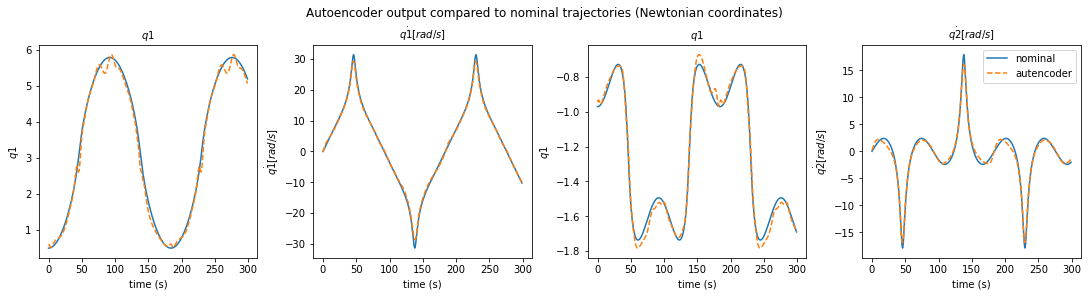

In [117]:
x,y = next(iter(test_loader))
print(x.shape)

x = torch.permute(x,(0,2,1))
_,x_hat = autoencoder(x)

n=3
fig, ax = plt.subplots(1, 4,figsize=(15, 4), constrained_layout=True, sharex=True)
list_1 = [r'$q1$',r'$\dot{q1}[rad/s]$',r'$q1$',r'$\dot{q2}[rad/s]$']
list_2 = ['a','b','c','d']
for i in range(4):
    ax[i].plot(x[n,:,i],label='nominal')
    ax[i].plot(x_hat[n,:,i].detach(),'--',label='autencoder')
    ax[i].set_title(list_1[i], fontsize=10)
    ax[i].set_ylabel(list_1[i])
    ax[i].set_xlabel('time (s)')

ax[3].legend()
plt.suptitle('Autoencoder output compared to nominal trajectories (Newtonian coordinates)')
plt.savefig('./img/autoencoder.png', format="png",dpi=400)
plt.show()

In [48]:
model = load_model()

In [113]:
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, activation='tanh', config = 'encoded') # 'x+sin(x)^2'

count_parameters(autoencoder)

9480

In [111]:
1/x.std(dim=(0,2))

tensor([0.2824, 0.0779, 0.7157, 0.1956])

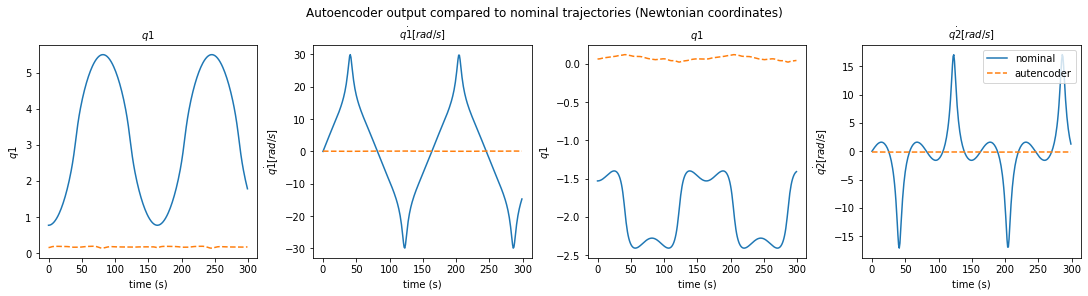

epoch    0 | train time 0.67 | train loss 3.881819e+02 
epoch   20 | train time 0.07 | train loss 2.677740e+02 
epoch   40 | train time 0.07 | train loss 1.684533e+02 


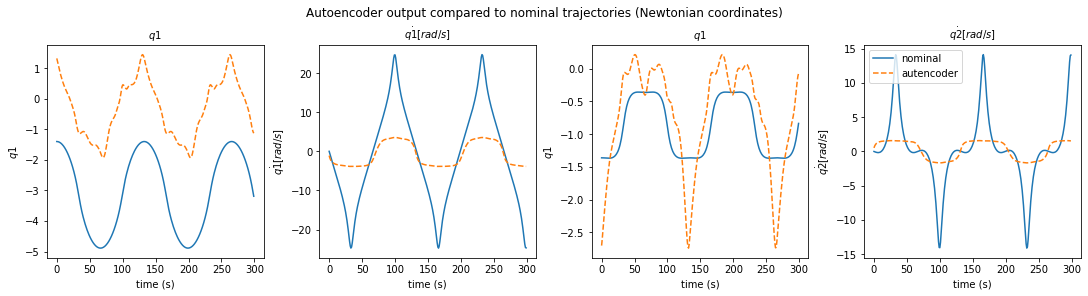

epoch   60 | train time 0.07 | train loss 1.219006e+02 
epoch   80 | train time 0.07 | train loss 9.305676e+01 


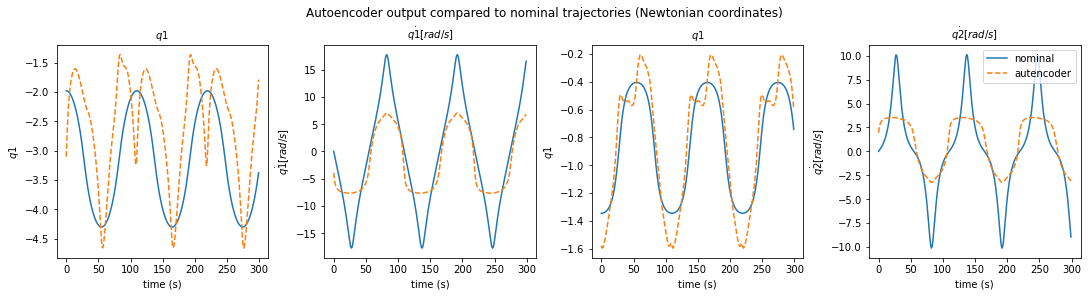

epoch  100 | train time 0.76 | train loss 7.442331e+01 
epoch  120 | train time 0.07 | train loss 6.263686e+01 
epoch  140 | train time 0.11 | train loss 5.438558e+01 


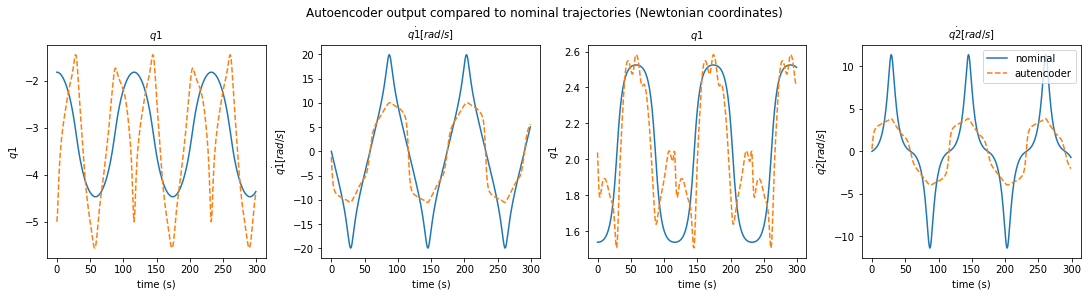

epoch  160 | train time 0.06 | train loss 4.795860e+01 
epoch  180 | train time 0.07 | train loss 4.277620e+01 


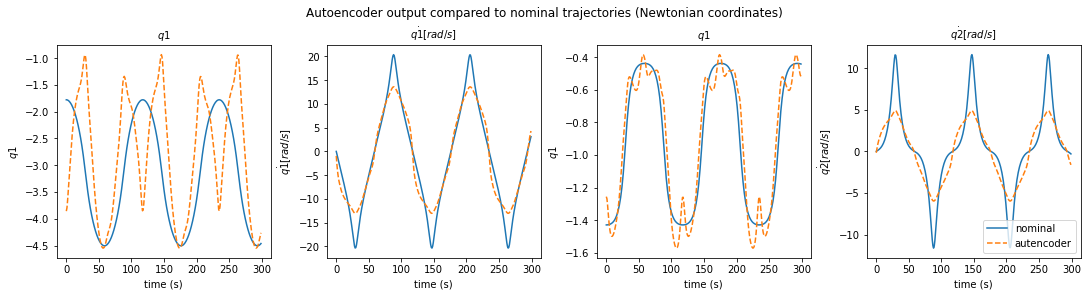

epoch  200 | train time 0.72 | train loss 3.800512e+01 
epoch  220 | train time 0.07 | train loss 3.348872e+01 
epoch  240 | train time 0.07 | train loss 2.921437e+01 


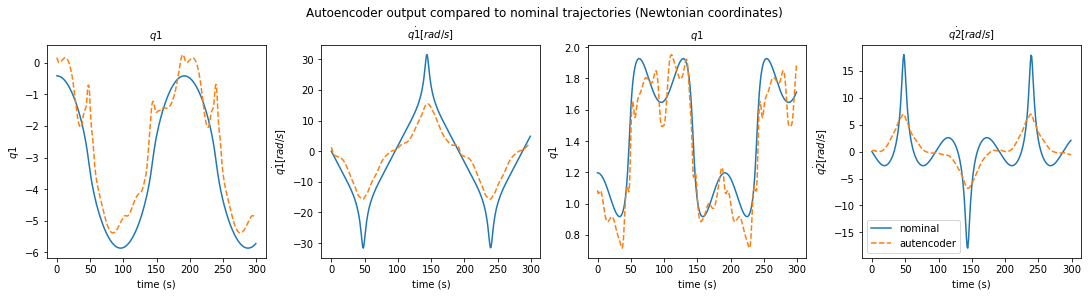

epoch  260 | train time 0.07 | train loss 2.537823e+01 
epoch  280 | train time 0.06 | train loss 2.134264e+01 


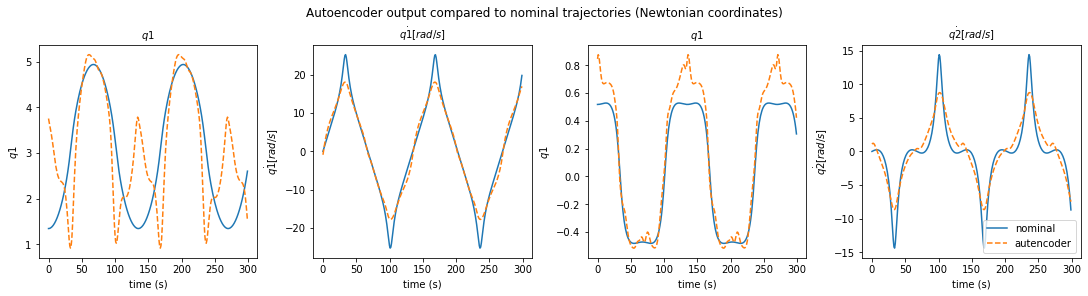

epoch  300 | train time 0.65 | train loss 1.762505e+01 
epoch  320 | train time 0.06 | train loss 1.476597e+01 
epoch  340 | train time 0.07 | train loss 1.274365e+01 


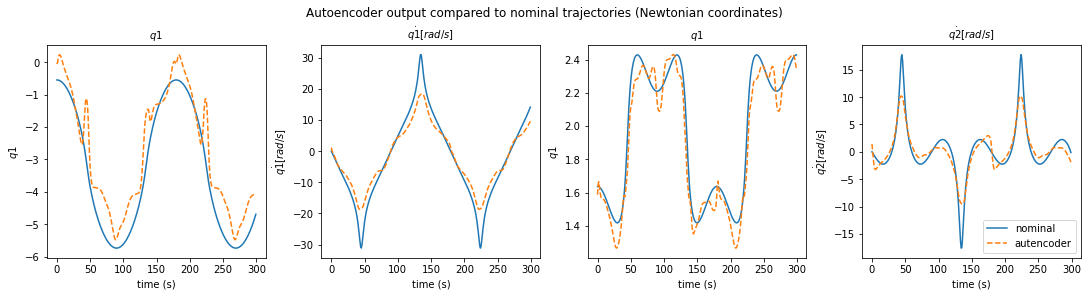

epoch  360 | train time 0.07 | train loss 1.126822e+01 
epoch  380 | train time 0.07 | train loss 1.026197e+01 


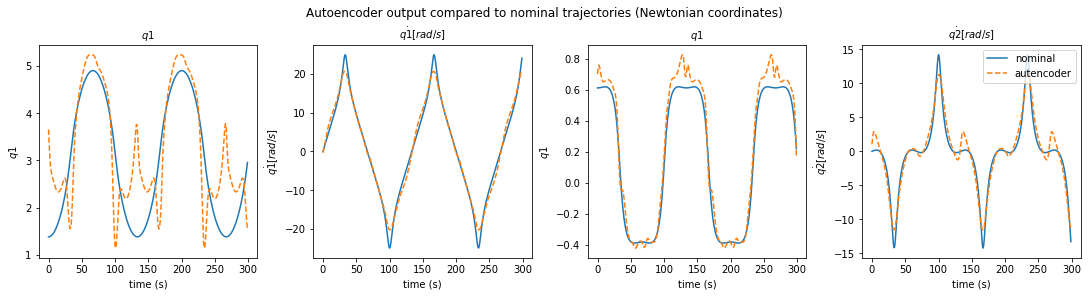

epoch  400 | train time 0.78 | train loss 9.350382e+00 
epoch  420 | train time 0.07 | train loss 8.574138e+00 
epoch  440 | train time 0.07 | train loss 7.916742e+00 


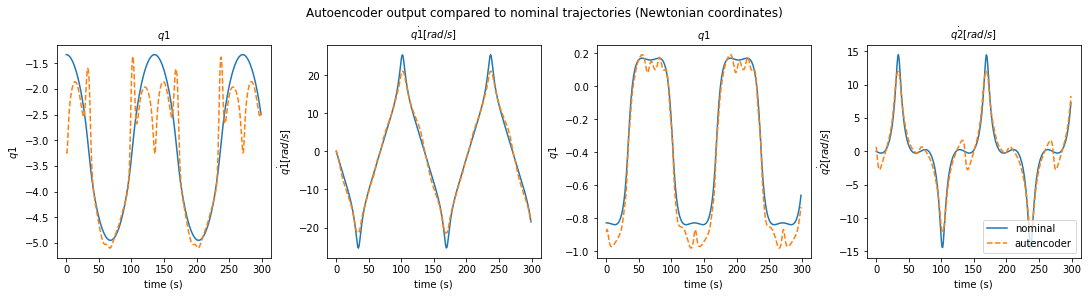

epoch  460 | train time 0.06 | train loss 7.339455e+00 
epoch  480 | train time 0.07 | train loss 7.993421e+00 


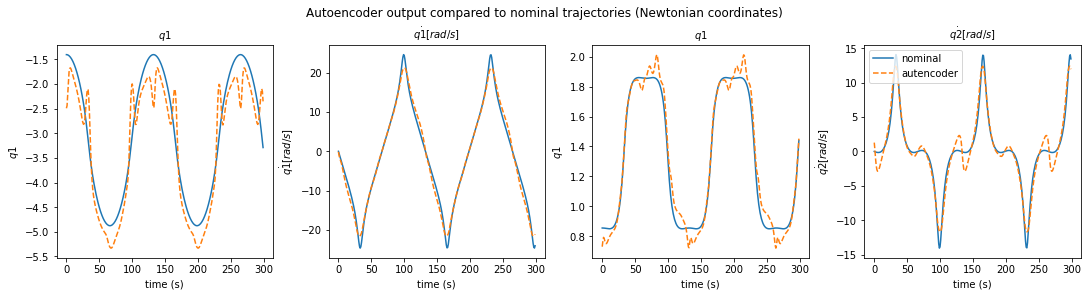

epoch  500 | train time 0.72 | train loss 6.481760e+00 
epoch  520 | train time 0.08 | train loss 6.023626e+00 
epoch  540 | train time 0.08 | train loss 5.642056e+00 


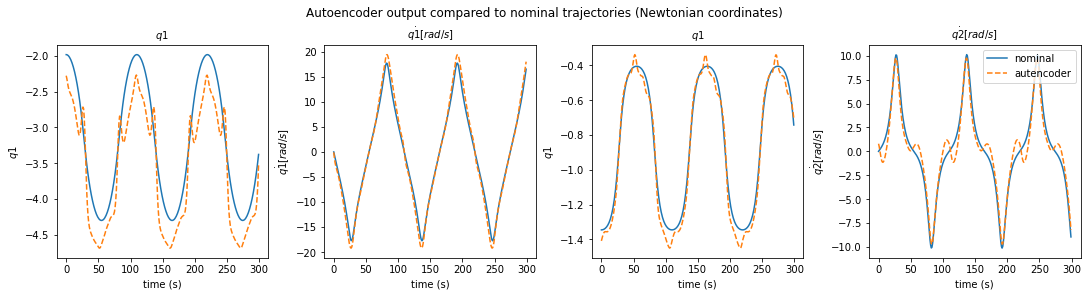

epoch  560 | train time 0.07 | train loss 5.306687e+00 
epoch  580 | train time 0.07 | train loss 5.012234e+00 


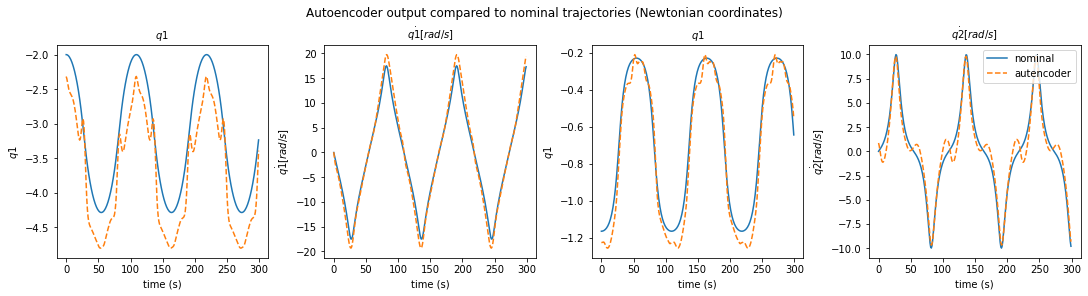

epoch  600 | train time 0.87 | train loss 5.028827e+00 
epoch  620 | train time 0.07 | train loss 4.511707e+00 
epoch  640 | train time 0.07 | train loss 4.274944e+00 


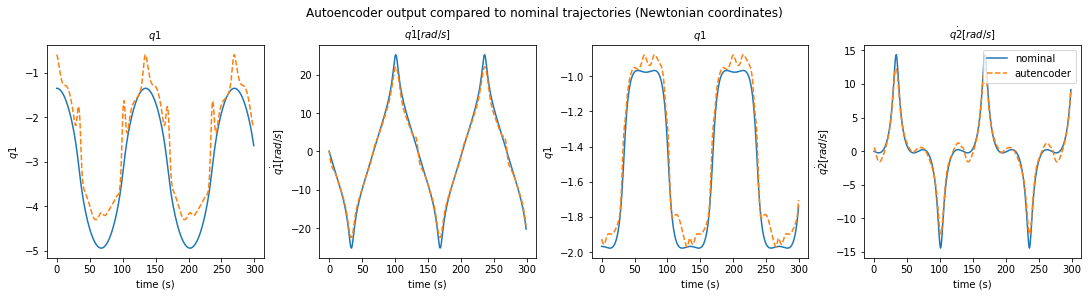

epoch  660 | train time 0.08 | train loss 4.062025e+00 
epoch  680 | train time 0.07 | train loss 3.861876e+00 


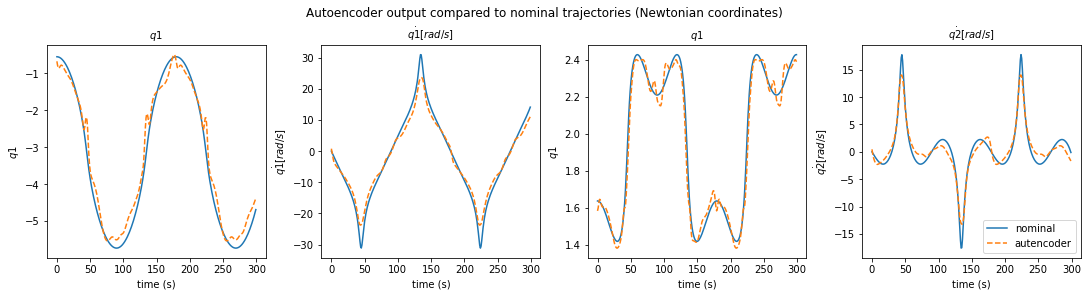

epoch  700 | train time 0.68 | train loss 3.674262e+00 
epoch  720 | train time 0.06 | train loss 4.273899e+00 
epoch  740 | train time 0.08 | train loss 3.440578e+00 


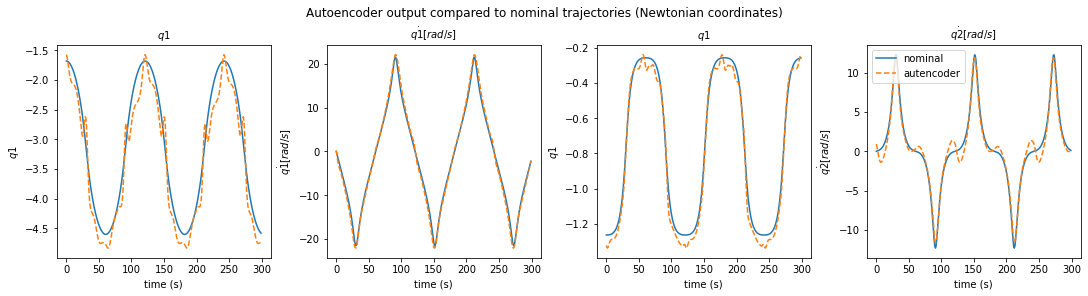

epoch  760 | train time 0.08 | train loss 3.221854e+00 
epoch  780 | train time 0.08 | train loss 3.083558e+00 


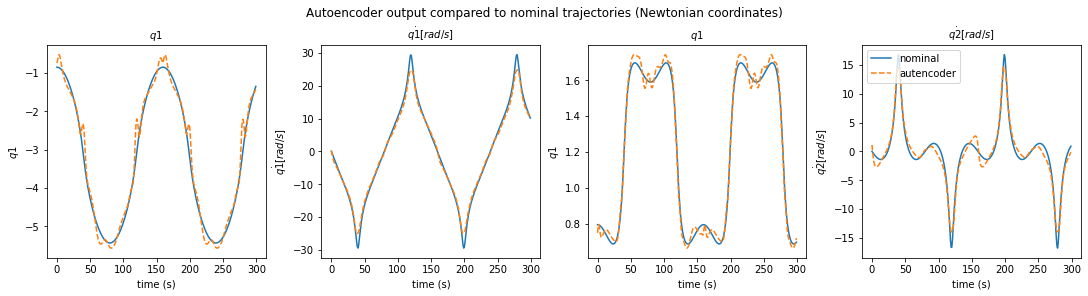

epoch  800 | train time 0.83 | train loss 2.954233e+00 
epoch  820 | train time 0.07 | train loss 2.853265e+00 
epoch  840 | train time 0.07 | train loss 2.942118e+00 


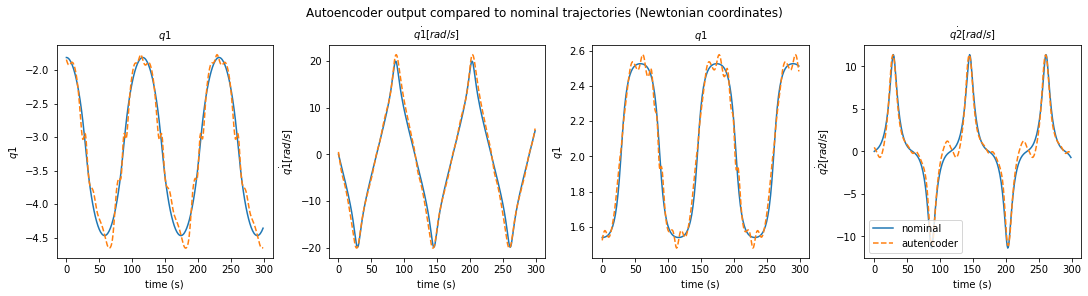

epoch  860 | train time 0.07 | train loss 2.679841e+00 
epoch  880 | train time 0.07 | train loss 2.548868e+00 


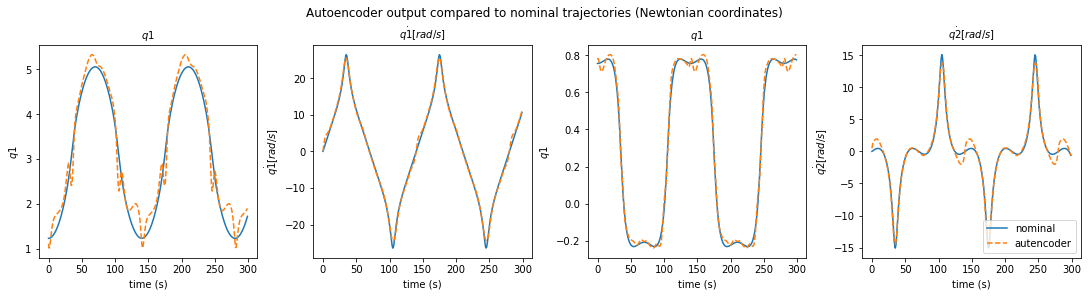

epoch  900 | train time 0.73 | train loss 2.451851e+00 
epoch  920 | train time 0.07 | train loss 2.365800e+00 
epoch  940 | train time 0.07 | train loss 2.313461e+00 


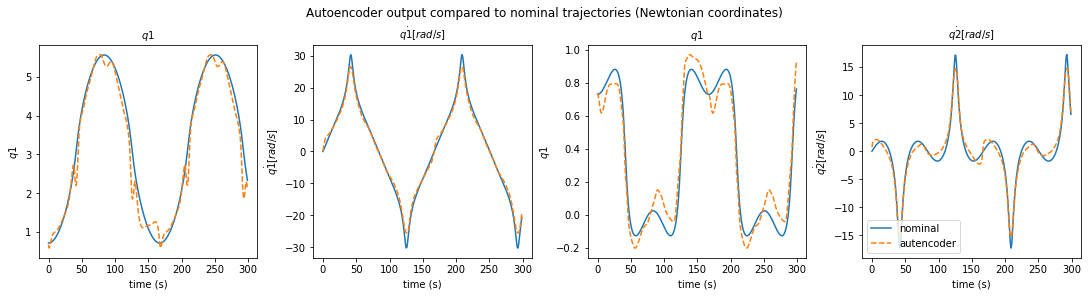

epoch  960 | train time 0.08 | train loss 2.399486e+00 
epoch  980 | train time 0.07 | train loss 2.175965e+00 


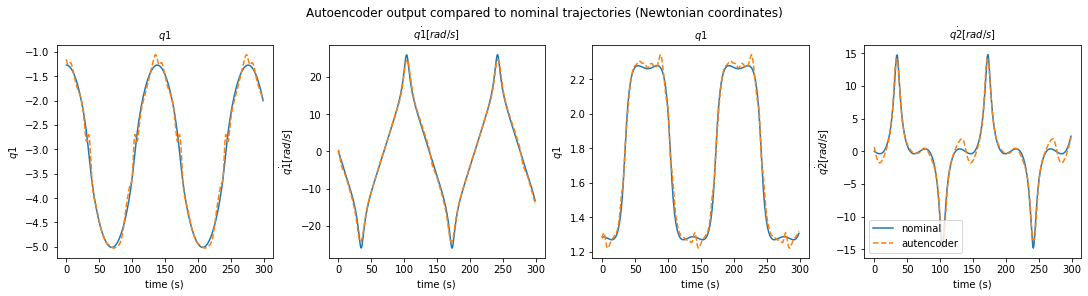

epoch 1000 | train time 0.76 | train loss 2.086955e+00 
epoch 1020 | train time 0.07 | train loss 2.018374e+00 
epoch 1040 | train time 0.08 | train loss 1.955146e+00 


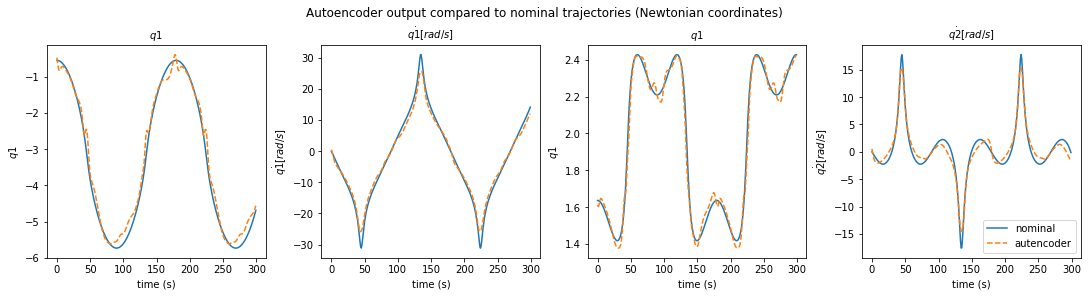

epoch 1060 | train time 0.08 | train loss 1.894415e+00 
epoch 1080 | train time 0.08 | train loss 3.240272e+00 


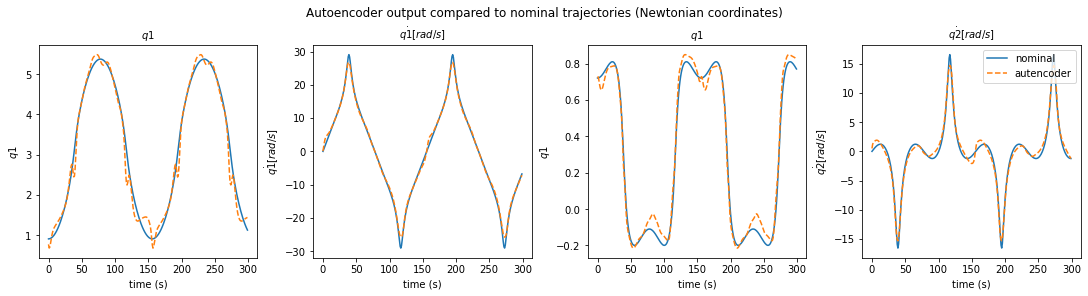

epoch 1100 | train time 0.71 | train loss 1.931339e+00 
epoch 1120 | train time 0.08 | train loss 1.753653e+00 
epoch 1140 | train time 0.08 | train loss 1.697068e+00 


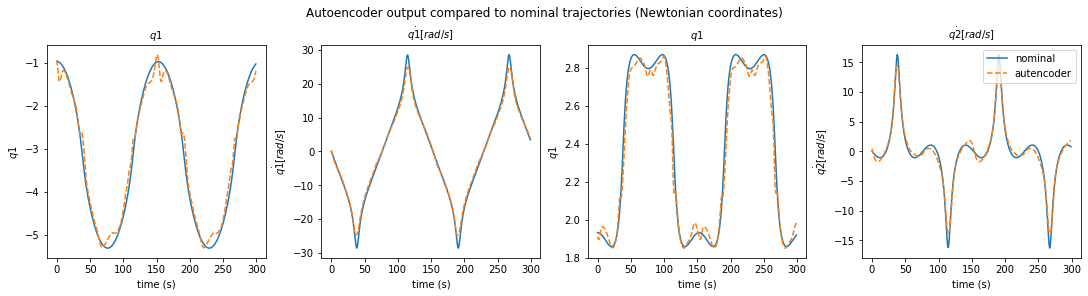

epoch 1160 | train time 0.06 | train loss 1.647415e+00 
epoch 1180 | train time 0.07 | train loss 1.600024e+00 


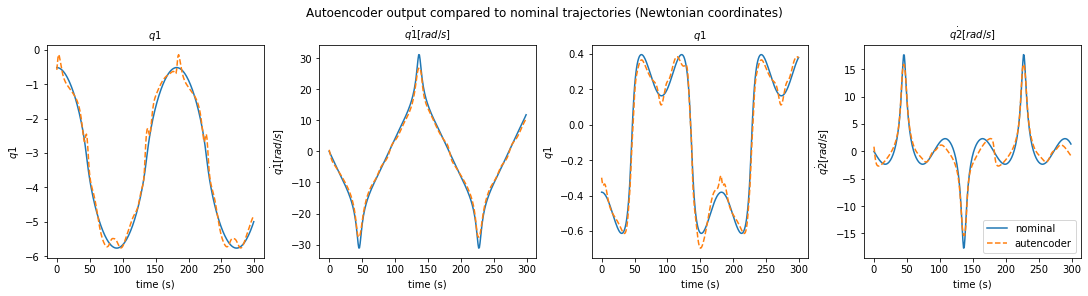

epoch 1200 | train time 0.70 | train loss 1.553937e+00 
epoch 1220 | train time 0.07 | train loss 1.508965e+00 
epoch 1240 | train time 0.08 | train loss 3.824758e+00 


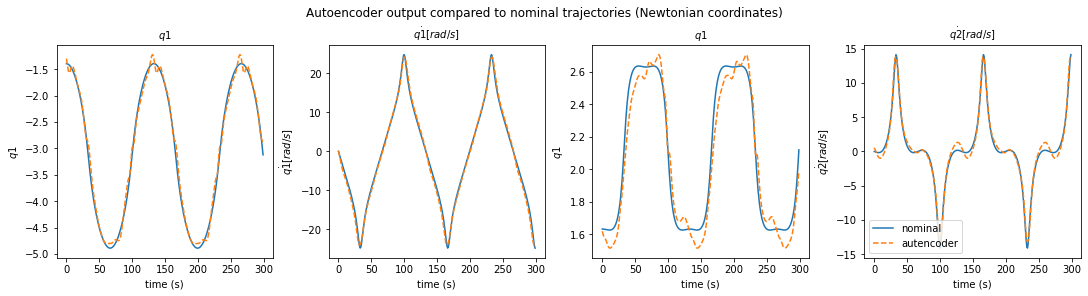

epoch 1260 | train time 0.08 | train loss 1.665104e+00 
epoch 1280 | train time 0.07 | train loss 1.427664e+00 


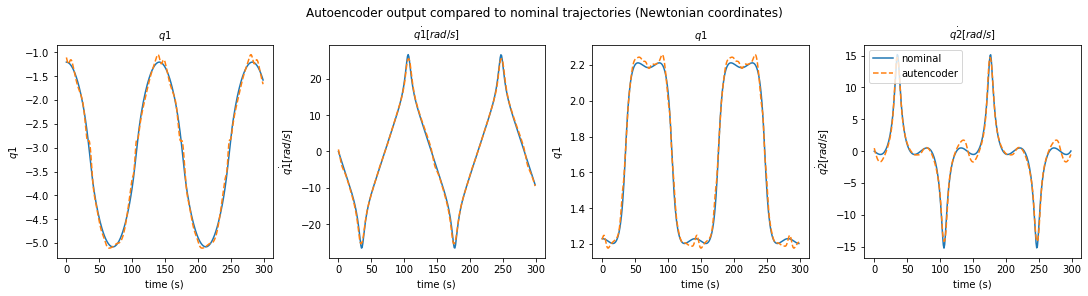

epoch 1300 | train time 0.71 | train loss 1.364511e+00 
epoch 1320 | train time 0.08 | train loss 1.324676e+00 
epoch 1340 | train time 0.07 | train loss 1.287803e+00 


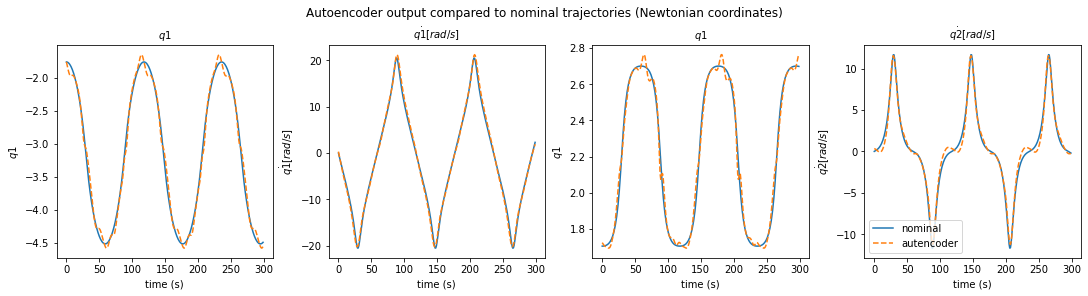

epoch 1360 | train time 0.08 | train loss 1.251782e+00 
epoch 1380 | train time 0.07 | train loss 1.216630e+00 


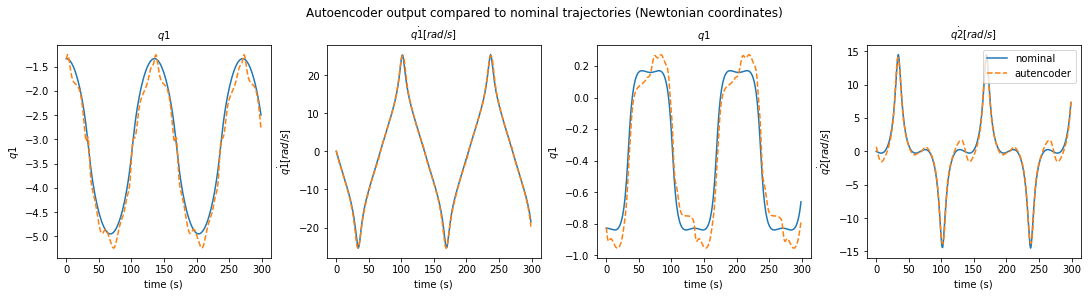

epoch 1400 | train time 0.67 | train loss 1.970300e+00 
epoch 1420 | train time 0.09 | train loss 1.235427e+00 
epoch 1440 | train time 0.13 | train loss 1.140578e+00 


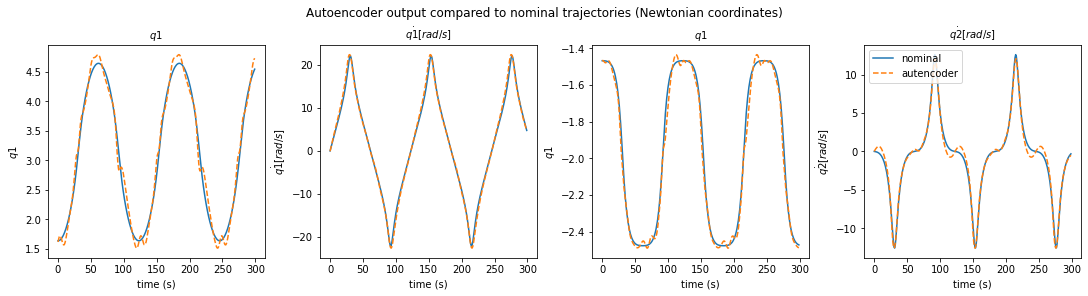

epoch 1460 | train time 0.08 | train loss 1.095335e+00 
epoch 1480 | train time 0.07 | train loss 1.065090e+00 


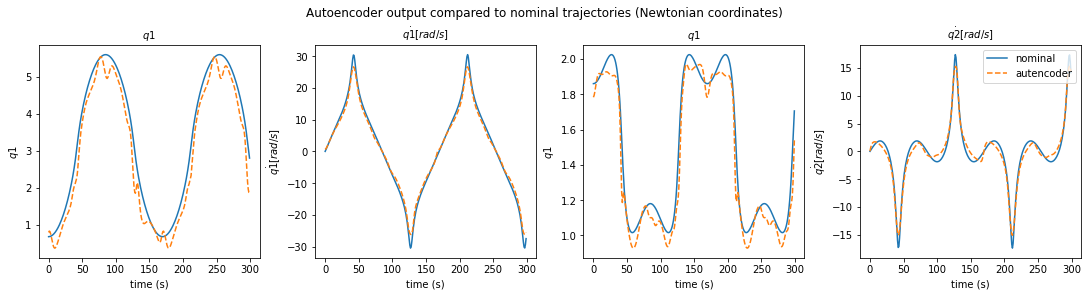

epoch 1500 | train time 0.85 | train loss 1.046125e+00 
epoch 1520 | train time 0.07 | train loss 1.088984e+00 
epoch 1540 | train time 0.07 | train loss 1.009978e+00 


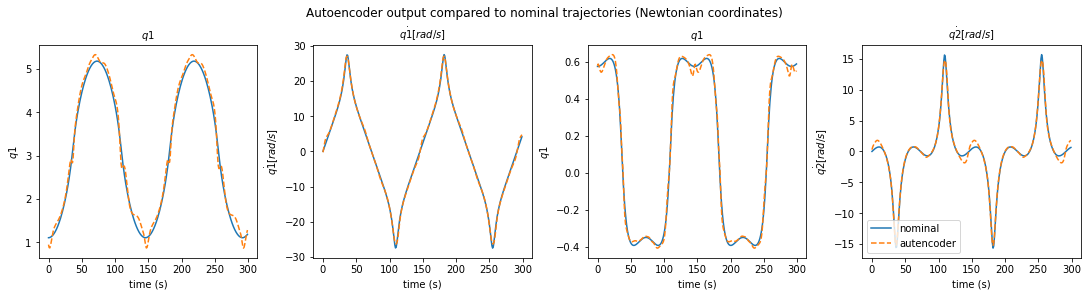

epoch 1560 | train time 0.09 | train loss 9.626839e-01 
epoch 1580 | train time 0.09 | train loss 9.349091e-01 


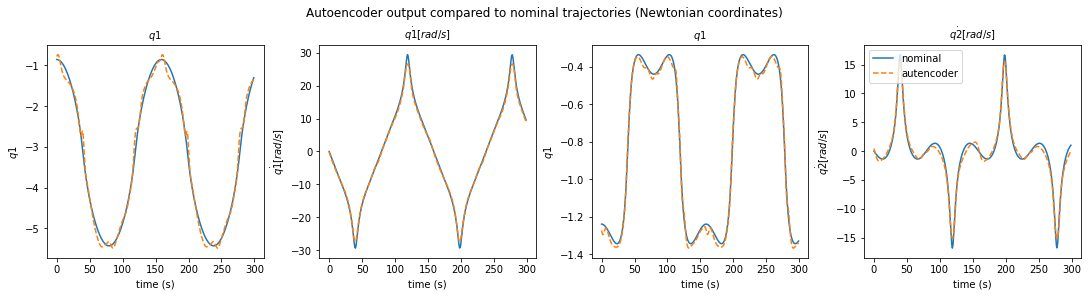

epoch 1600 | train time 0.84 | train loss 9.091628e-01 
epoch 1620 | train time 0.08 | train loss 8.842586e-01 
epoch 1640 | train time 0.07 | train loss 8.829325e-01 


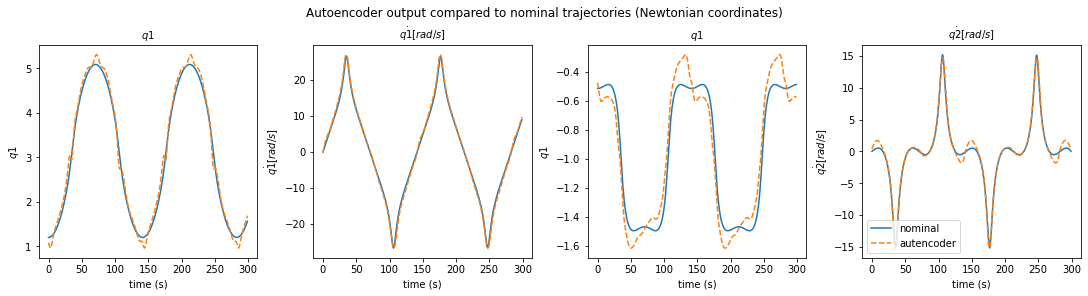

epoch 1660 | train time 0.09 | train loss 1.082551e+00 
epoch 1680 | train time 0.07 | train loss 8.472112e-01 


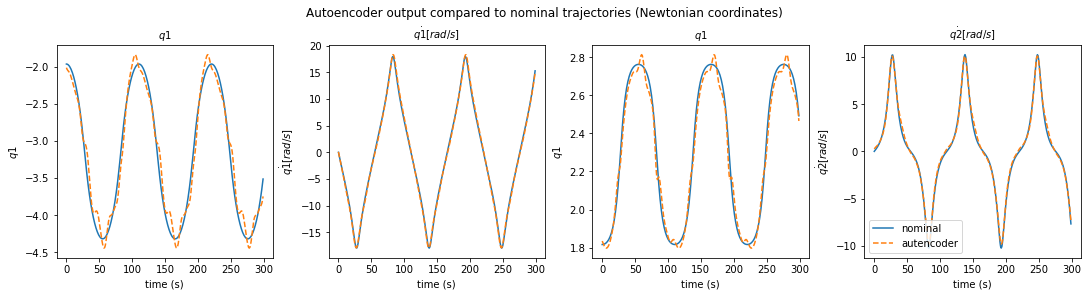

epoch 1700 | train time 0.73 | train loss 8.066524e-01 
epoch 1720 | train time 0.07 | train loss 7.802123e-01 
epoch 1740 | train time 0.06 | train loss 7.596194e-01 


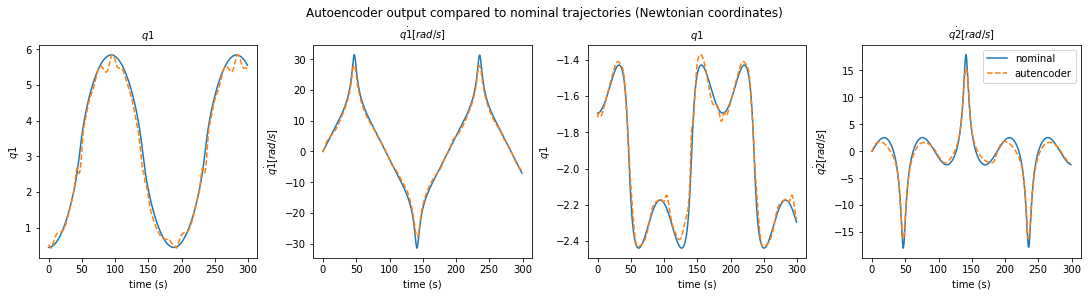

epoch 1760 | train time 0.07 | train loss 1.290810e+00 
epoch 1780 | train time 0.16 | train loss 8.399302e-01 


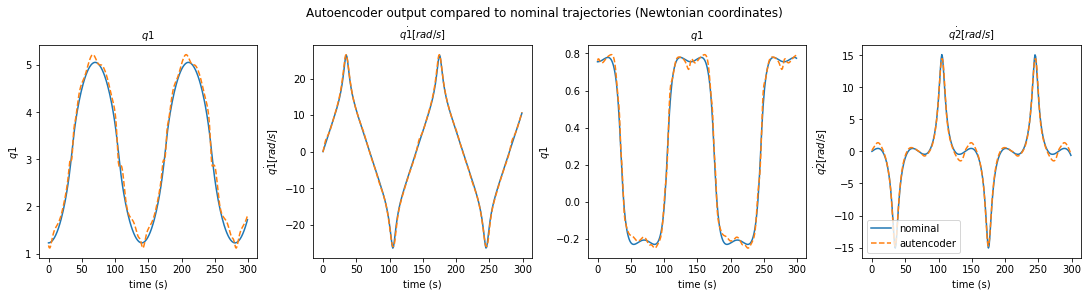

epoch 1800 | train time 0.67 | train loss 7.269506e-01 
epoch 1820 | train time 0.08 | train loss 6.921061e-01 
epoch 1840 | train time 0.10 | train loss 6.734850e-01 


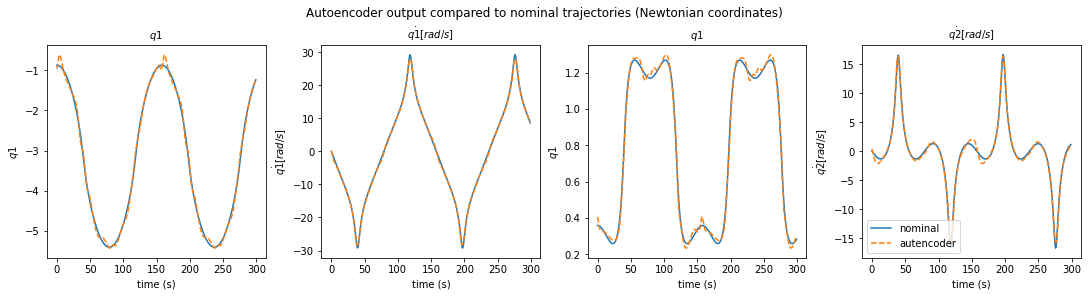

epoch 1860 | train time 0.09 | train loss 6.560407e-01 
epoch 1880 | train time 0.08 | train loss 6.393418e-01 


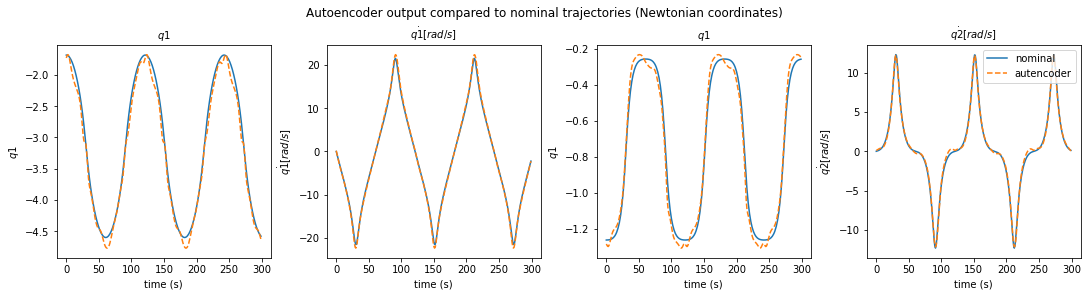

epoch 1900 | train time 0.78 | train loss 7.892832e-01 
epoch 1920 | train time 0.08 | train loss 8.463224e-01 
epoch 1940 | train time 0.08 | train loss 6.135889e-01 


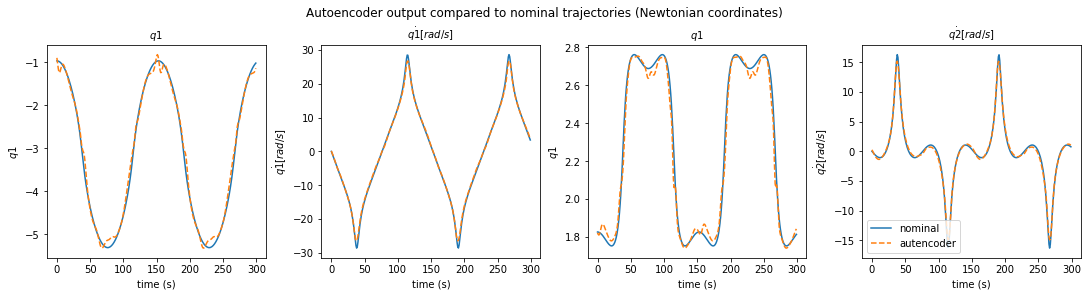

epoch 1960 | train time 0.09 | train loss 5.886129e-01 
epoch 1980 | train time 0.06 | train loss 5.715582e-01 


In [114]:
stats_2 = train_only_ae(autoencoder, 
                        model, 
                        train_loader, 
                        test_loader, 
                        epochs=2000, 
                        horizon=300, 
                        lr = 1e-3,
                        w = torch.tensor([2.0,0.8,10.0,1.0]))

## AE and HNN

### horizon function

In [69]:
def select_horizon(step,switch_steps = (200,200,150,150,150)  ):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    n1, n2, n3, n4, n5 = switch_steps
    # n1 number of steps with a horizon =  50
    # n2 number of steps with a horizon =  100
    # n3 number of steps with a horizon =  150
    # n4 number of steps with a horizon =  200
    # n5 number of steps with a horizon =  250
    # horizon = 300 for the remainder of training steps 
    if step <=n1:
        horizon = 50
        if step==0:
            print('horizon length :', horizon)
    elif (step > n1)&(step <= n1+n2):
        horizon = 100
        if step==n1+1:
            print('horizon length :', horizon)
    elif (step > n1+n2)&(step <= n1+n2+n3):
        horizon = 150
        if step==n1+n2+1:
            print('horizon length :', horizon)
    elif (step > n1+n2+n3)&(step <= n1+n2+n3+n4):
        horizon = 200
        if step==n1+n2+n3+1:
            print('horizon length :', horizon)
    elif (step > n1+n2+n3+n4)&(step <= n1+n2+n3+n4+n5):
        horizon = 250
        if step==n1+n2+n3+n4+1:
            print('horizon length :', horizon)
    else :
        horizon = 300
        if step==n1+n2+n3+n4+n5+1:
            print('horizon length :', horizon)
    return horizon

In [70]:
def select_horizon_wschedule(step,optim,epoch_number, 
                             switch_steps = (200,200,150,150,150)       
                            ):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    n1, n2, n3, n4, n5 = switch_steps
    # n1 number of steps with a horizon =  50
    # n2 number of steps with a horizon =  100
    # n3 number of steps with a horizon =  150
    # n4 number of steps with a horizon =  200
    # n5 number of steps with a horizon =  250
    # horizon = 300 for the remainder of training steps 

    if step <=n1:
        horizon = 50
        if step==0:
            print('horizon length :', horizon)
            # steps = n1
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0   
        do_step = False
            
    elif (step > n1)&(step <= n1+n2):
        horizon = 100
        if step==n1+1:
            print('horizon length :', horizon)
            # steps = n2
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0   
        do_step = False
    elif (step > n1+n2)&(step <= n1+n2+n3):
        horizon = 150
        if step==n1+n2+1:
            print('horizon length :', horizon)
            # steps = n3
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0   
        do_step = False
    elif (step > n1+n2+n3)&(step <= n1+n2+n3+n4):
        horizon = 200
        if step==n1+n2+n3+1:
            print('horizon length :', horizon)
            # steps = n4
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0     
        do_step = False
    elif (step > n1+n2+n3+n4)&(step <= n1+n2+n3+n4+n5):
        horizon = 250
        if step==n1+n2+n3+n4+1:
            print('horizon length :', horizon)
            # steps = n5
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0     
        do_step = False
    else :
        horizon = 300
        do_step = True
        num_steps = 0
        if step==n1+n2+n3+n4+n5+1:
            print('horizon length :', horizon)
            num_steps = epoch_number - (n1+n2+n3+n4+n5)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_steps)

    return horizon, num_steps

### Train function

In [86]:
def train_ae(model, 
             autoencoder,
             train_loader, 
             test_loader, 
             horizon=False, 
             horizon_type=False, 
             switch_steps = (200,200,150,150,150),
             steps_ae = 5,
             epochs = 20,
             epoch_number = 1000,
             w=torch.tensor([0.1,0.1,1.0,1.0], device=device)): 
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    
    alpha = 1.0
    beta = 1.0
    gamma = 1.0

    lr = 1e-3
    Ts = 0.005
    params = list(model.parameters()) + list(autoencoder.parameters())
    optim = torch.optim.Adam(params, lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function

    
    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        ae_loss = 0
        t1 = time.time()
        if horizon_type == 'schedule':
            horizon, scheduler = select_horizon_wschedule(step,optim,
                                                          epoch_number,
                                                          switch_steps)
        elif horizon_type == 'auto': 
            horizon = select_horizon(step, switch_steps)

        for x, t_eval in iter(train_loader): # x is [batch_size,(q1,p1,q2,p1),time_steps]
            
            t_eval = t_eval[0,:horizon]
            x = torch.permute(x,(0,2,1)) # now x is [batch_size,time_steps,(q1,p1,q2,p1)]

            # x_hat is the reconstructed nominal trajectory ; q_dot_hat = decoder(encoder(nominaltrajectory))
            # z is nominal trajectory in latent space (encoded nominal trajectory)
            z, x_hat = autoencoder(x[:, :horizon, :])
            
            # model output in latent space
            train_z_hat = odeint(model, z[:,0,:], t_eval, method='rk4', options=dict(step_size=Ts))
            # train_z_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 

            # decoded output trajectory
            train_x_hat = autoencoder.decoder(train_z_hat[:horizon,:,:])
            # train_x_hat = [time_steps, batch_size, (q1_HNN_decoded, p1_HNN_decoded, q2_HNN_decoded, p1_HNN_decoded)] 

            # print('x: ',x.shape)
            # print('z: ',z.shape)
            # print('x_hat: ',x_hat.shape)
            # print('train_z_hat: ',train_z_hat.shape)
            # print('train_x_hat: ',train_x_hat.shape)   

            # x:  torch.Size([100, 300, 4])
            # z:  torch.Size([100, 50, 4])
            # x_hat:  torch.Size([100, 50, 4])
            # train_z_hat:  torch.Size([50, 100, 4])
            # train_x_hat:  torch.Size([50, 100, 4])

            # loss between HNN output and encoded nominal trajectory (nominal trajectory in latent space)
            loss_HNN_batch = L2_loss(torch.permute(z[:, :, :], (1,0,2)), train_x_hat[:,:,:],w) #[:,:horizon])

            # loss between decoded HNN output and nominal trajectory 

            loss_prediction_batch = L2_loss(x[:, :horizon, :], torch.permute(train_x_hat[:,:,:],(1,0,2)),w) 

            # loss between nominal trajectory and decoded(encoded(nominaltrajectory))
            # to make sure the autoencoder properly reconstructs the nominal trajectory
            loss_AE_batch = L2_loss(x[:, :horizon, :], x_hat[:,:horizon,:],w)

            # train_loss_batch = L2_loss(torch.permute(z[:, :, :horizon], (2,0,1)) , train_z_hat[:horizon,:,:],w)#[:,:horizon])
            train_loss_batch = alpha*loss_HNN_batch + beta*loss_prediction_batch + gamma*loss_AE_batch
            
            train_loss = train_loss + train_loss_batch.item() 
            train_loss_batch.backward() 
            optim.step() 
            optim.zero_grad(set_to_none=True) 

        t2 = time.time()
        train_time = t2-t1

        if test_loader: 
            if not (step%10): # run validation every 10 steps
                for x, t_eval in iter(test_loader):
                    # run test data
                    t_eval = t_eval[0,:horizon]
   
                    test_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4')      
                    test_loss_batch = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                    test_loss = test_loss + test_loss_batch.item()
                test_time = time.time()-t2
                print('epoch {:4d} | train time {:.2f} | train loss {:12e} | test loss {:8e} | test time {:.2f}  '
                      .format(step, train_time, train_loss, test_loss,test_time))
                stats['test_loss'].append(test_loss)
            else:
                print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
                      .format(step, train_time, train_loss))
        else:
            print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
                  .format(step, train_time, train_loss))
        # logging
        stats['train_loss'].append(train_loss)
        
    return stats

In [84]:
model = load_model()
count_parameters(model)

autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, activation='tanh', config = 'encoded') # 'x+sin(x)^2'

count_parameters(autoencoder)

9480

In [87]:
train_ae(model, 
             autoencoder,
             train_loader, 
             test_loader, 
             horizon=False, 
             horizon_type='auto', 
             switch_steps = (200,200,150,150,150),
             steps_ae = 5,
             epochs = 20,
             epoch_number = 1000,
             w=torch.tensor([0.1,0.1,1.0,1.0], device=device))

horizon length : 50
epoch    0 | train time 2.26 | train loss 7.291129e+01 | test loss 3.908850e+01 | test time 0.39  
epoch    1 | train time 1.69 | train loss 7.190205e+01 
epoch    2 | train time 1.78 | train loss 7.086768e+01 


KeyboardInterrupt: 